In [2]:
# TODO: Solution quality against problem size
# TODO: Number of qubits (in embedding) against problem size (logical variables)
# TODO: Time to solution against problem size

import networkx as nx
import matplotlib.pyplot as plt
import json
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

from dimod import BinaryQuadraticModel
from dwave.samplers import SteepestDescentSolver, SimulatedAnnealingSampler
from dwave.system import DWaveSampler, FixedEmbeddingComposite
import dwave_networkx as dnx
import dwave.inspector

from plotters import plotHistogram, plotBoundaryStrength, plotSampleGraph, plotArrangement, annotateSampleGraph, plotCSV
from qubo import createBQM
from sampleRecording import recordSample, findOverlaps, totalEntropy

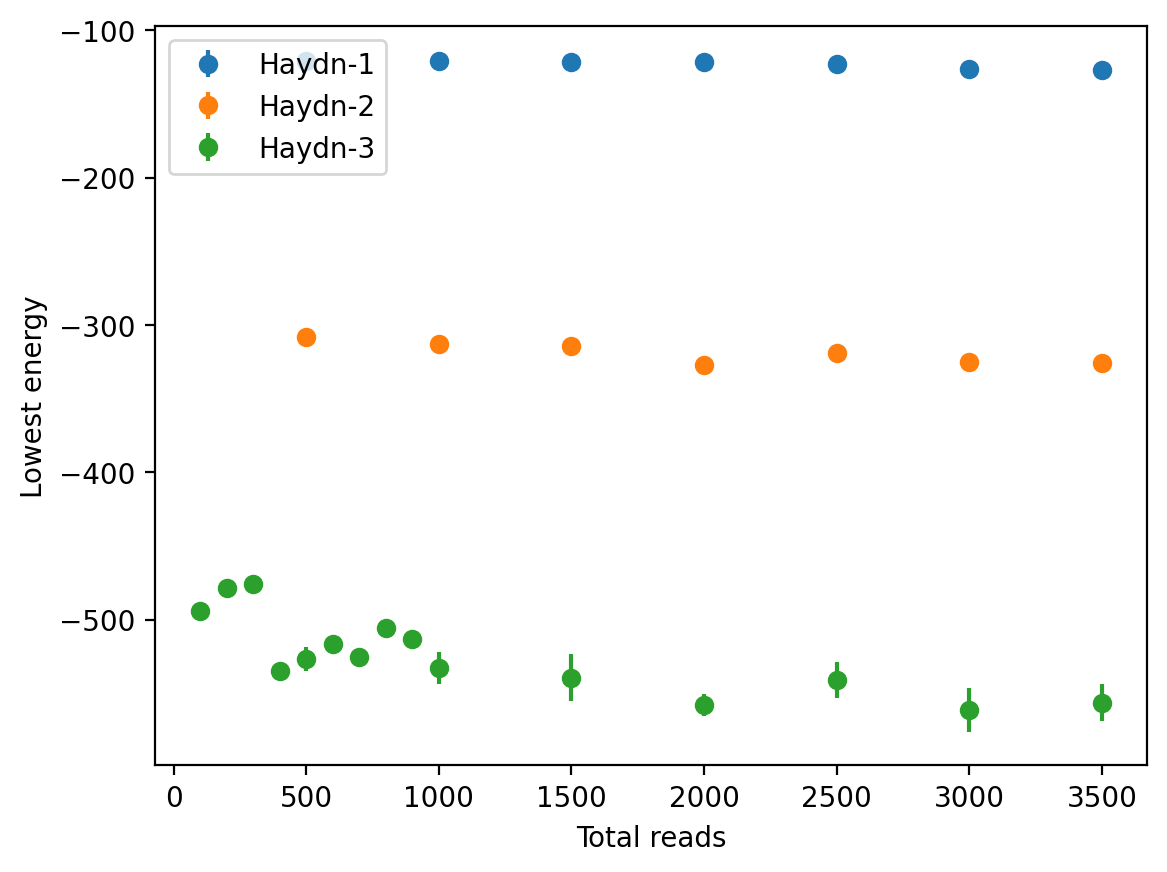

In [8]:
identifiers = ["Haydn-1", "Haydn-2", "Haydn-3"]
embeddings = []
bqms = []

def plotNormalisedReads(path: str, parameter: str):

    data = pd.read_csv(path + "qa-reads.csv")
    range = data["Total reads"].unique()

    bqm = BinaryQuadraticModel.from_serializable(json.load(open(path + "bqm.json", "r")))
    variables = len(bqm.linear)

    means = []
    stderr = []

    for r in range:
        query = data.query(f"`Total reads` == {r}")[parameter]
        means.append(np.mean(query) / variables) # Normalise by number of variables
        stderr.append(np.std(query) / np.sqrt(len(query)) / variables)

    plt.errorbar(range, means, yerr=stderr, fmt='o', label=i)
    plt.xlabel("Total reads")
    plt.ylabel(f"{parameter} (normalised)")

for i in identifiers:
    path = f"../Pickles/{i}/{i}_"

    bqm = BinaryQuadraticModel.from_serializable(json.load(open(path + "bqm.json", "r")))
    embedding = json.load(open(path + "embedding.json", "r"))
    
    bqms.append(bqm)
    embeddings.append(embedding)
    
    variables = len(bqm.linear)
    qubits = sum(len(i) for i in embedding.values())

    #plotNormalisedReads(path, "Lowest energy")

    plotCSV(path+"qa-reads.csv", "Total reads", "Lowest energy", label=i)
   
#plt.ylim(-1,0)
plt.legend()
plt.show()

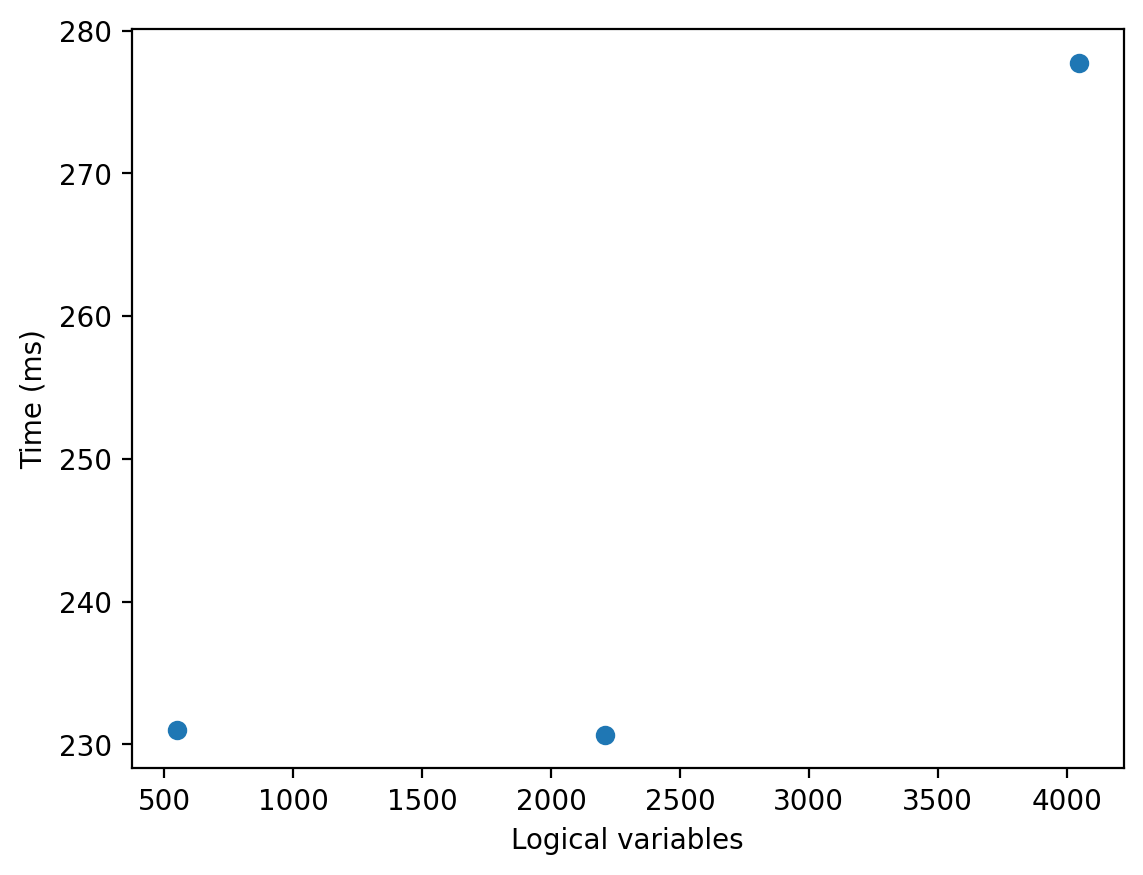

In [3]:
def plotTimeVariables(filename: str, identifiers: list[str], reads: int = 1000):

    variables = []
    entries = []
    means = []
    stderr = []

    for i in identifiers:
        path = f"../Pickles/{i}/{i}_"
        
        embedding = json.load(open(path + "embedding.json", "r"))
        bqm = BinaryQuadraticModel.from_serializable(json.load(open(path + "bqm.json", "r")))

        variables.append(len(embedding))
        entries.append(sum(bqm.shape))

        data = pd.read_csv(path+filename)
        query = data.query(f"`Total reads` == {reads}")["Time"]
        means.append(np.mean(query)/1000)
        stderr.append(np.std(query)/np.sqrt(len(query))/1000)

    plt.errorbar(entries, means, yerr=stderr, fmt='o')
    plt.xlabel("Logical variables")
    plt.ylabel("Time (ms)")

identifiers = ["Haydn-1", "Haydn-2", "Haydn-3"]
plotTimeVariables("qa-reads.csv", identifiers, 1000)

[549, 2211, 4046]


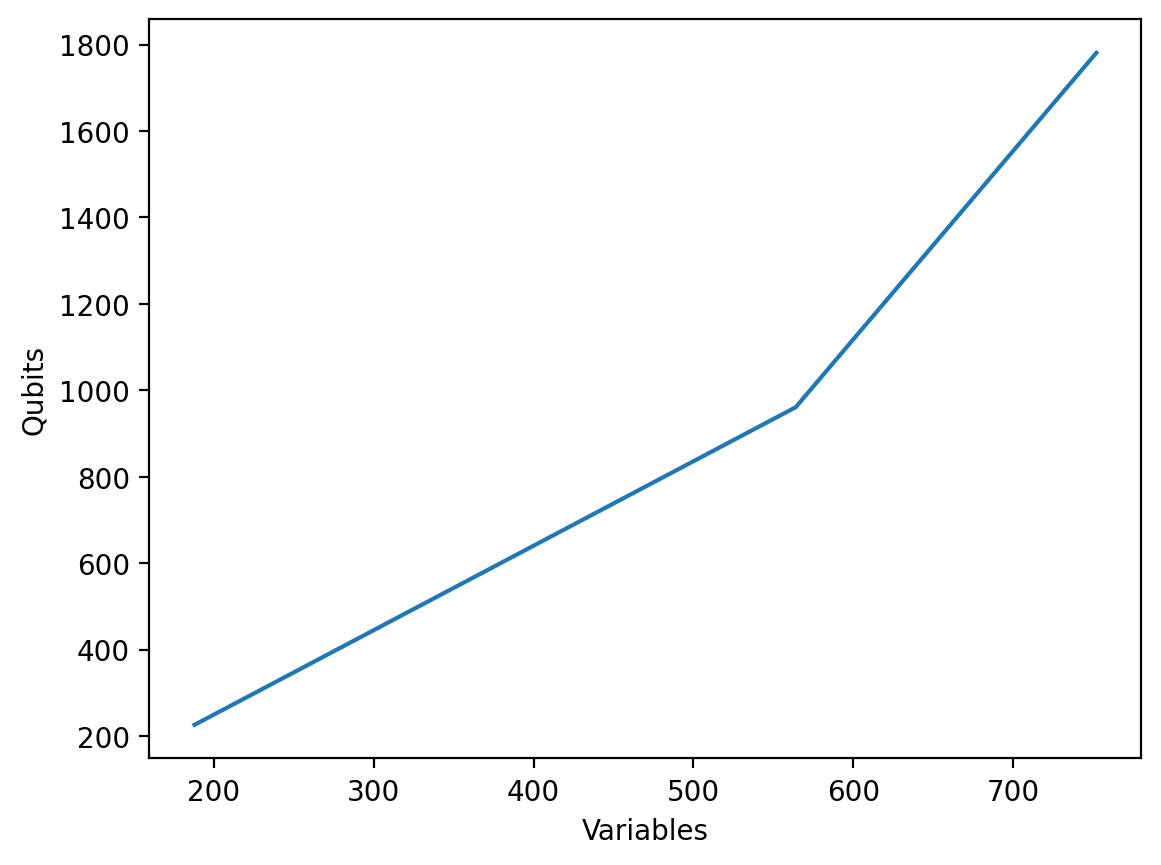

In [29]:
variables = [len(b.linear) for b in bqms]
qubits = [sum(len(i) for i in e.values()) for e in embeddings]

plt.plot(variables, qubits)
plt.xlabel("Variables")
plt.ylabel("Qubits")
# Now we have 752 variables in BQM instead of the WRONG 565 (188 * 3 + 1)

print([sum(b.shape) for b in bqms])

In [37]:
sampleset = sampler.sample(bqm, num_reads=100, label=f"Haydn_{100}")